In [ ]:
'''
Pending:
- Set dates in all_countries data as years (not floats)
- Try k-clustering
'''

# Exploring ACLED data
- Import excel file, add date column and export it as json
- Use json file for all future work
- Data formatting: column names. 
- Encode event_type and sub_event_type
- Aggregate by month
- Function to get a dataset for a specific country

In [1]:
# African dataset
# https://www.acleddata.com/curated-data-files/

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

## Exporting excel file as json

In [3]:
# # import excel file
# df = pd.read_excel('../data/Africa_1997-2019_Oct12-1.xlsx')

In [4]:
# # New column for date & month
# df['date'] = pd.to_datetime(df['EVENT_DATE']).dt.date

In [5]:
# # export dataframe as json
# df.to_json('../data/africa-data.json')

## Importing data

In [6]:
df = pd.read_json('../data/africa-data.json')

In [7]:
df.shape

(193565, 30)

In [74]:
# df.head()

## Data formatting
- Rename columns
- Encode values
- Define classification according to event/fatalities?

In [9]:
# Rename and remove columns
columns = ['YEAR', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1', 'REGION', 'COUNTRY', 'SOURCE', 'FATALITIES', 'date']
try:
    df = df[columns]
    df.columns = ['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country', 'source', 'fatalities', 'date']
except KeyError as e:
    print(e)
    pass

print(df.columns)
print(df.shape)

Index(['year', 'event_type', 'sub_event_type', 'actor', 'region', 'country',
       'source', 'fatalities', 'date'],
      dtype='object')
(193565, 9)


In [10]:
# Encode event_types and sub_event_types
# https://www.datacamp.com/community/tutorials/categorical-data

In [11]:
print('**Categorical values**\n')
print('{} event types:\n {}\n'.format(df.event_type.nunique(), df.event_type.unique()))
print('{} sub_event types:\n {}\n'.format(df.sub_event_type.nunique(), df.sub_event_type.unique()))
print('{} actors:\n {}\n'.format(df.actor.nunique(), df.actor.unique()))

**Categorical values**

6 event types:
 ['Violence against civilians' 'Explosions/Remote violence'
 'Strategic developments' 'Battles' 'Protests' 'Riots']

25 sub_event types:
 ['Attack' 'Remote explosive/landmine/IED' 'Abduction/forced disappearance'
 'Non-violent transfer of territory' 'Armed clash'
 'Looting/property destruction' 'Headquarters or base established'
 'Peaceful protest' 'Non-state actor overtakes territory'
 'Government regains territory' 'Protest with intervention'
 'Change to group/activity' 'Mob violence' 'Violent demonstration'
 'Sexual violence' 'Arrests' 'Air/drone strike'
 'Shelling/artillery/missile attack' 'Disrupted weapons use'
 'Excessive force against protesters' 'Agreement' 'Other' 'Grenade'
 'Suicide bomb' 'Chemical weapon']

4065 actors:
 ['GIA: Armed Islamic Group' 'GSPC: Salafist Group for Call and Combat'
 'Unidentified Armed Group (Angola)' ...
 'AFRC: Armed Forces Revolutionary Council (Advance Teams)'
 'Kakula Militia' 'Militia (Superman Faction)'

In [12]:
# Selecting labels for baseline model
labels = ['event_type','sub_event_type']
labels = df[labels]
labels.head()

,event_type,sub_event_type
0,Violence against civilians,Attack
1,Violence against civilians,Attack
10,Explosions/Remote violence,Remote explosive/landmine/IED
100,Explosions/Remote violence,Remote explosive/landmine/IED
1000,Violence against civilians,Abduction/forced disappearance


In [13]:
##### Encoding Labels

In [14]:
# Adding a boolean column for fatalities

df['fatalities_encoded'] = np.where(df['fatalities']>0, '1', '0')
df.head()

,year,event_type,sub_event_type,actor,region,country,source,fatalities,date,fatalities_encoded
0,1997,Violence against civilians,Attack,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,5,1997-01-01,1
1,1997,Violence against civilians,Attack,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,2,1997-01-02,1
10,1997,Explosions/Remote violence,Remote explosive/landmine/IED,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,20,1997-01-07,1
100,1997,Explosions/Remote violence,Remote explosive/landmine/IED,GIA: Armed Islamic Group,Northern Africa,Algeria,Algeria Watch,13,1997-08-29,1
1000,2003,Violence against civilians,Abduction/forced disappearance,GSPC: Salafist Group for Call and Combat,Northern Africa,Algeria,AFP,0,2003-03-08,0


In [15]:
# del df['fatalities_encoded']

In [16]:
# Using get_dummies for values with more than two levels

labels_encoded = pd.get_dummies(labels)

In [17]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)
all_labels = pd.concat([labels, labels_encoded], axis=1, sort=False)
# all_labels.iloc[2]

In [18]:
df = pd.concat([df, labels_encoded], axis = 1, sort = False)
# df.iloc[1]

## Function: Plot data for a specific country
- Resample all data by year
- Reshape all data to plot it as background
- Filter data by specific country, aggregate by year. 
- Plot data by specific country by year, with all the others for reference

In [47]:
# Basic summary data for all data
all_data = df.groupby(['date'])['event_type'].count()
all_data_year = all_data.resample('Y').sum()

In [77]:
# Pivot table to display data by country, year, sum(year)

all_countries = df.groupby(['year', 'country'])['event_type'].count().\
                reset_index(level=['year','country'])

all_countries = pd.pivot_table(all_countries, index= 'year', columns='country', values = 'event_type')


# Graph
# plt.rcParams['figure.figsize'] = (20, 10)
# all_countries.plot(subplots = False, style='-', alpha=0.3, color = 'gray')
# plt.legend().remove()

Index(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Republic of Congo',
       'Rwanda', 'Senegal', 'Sierra Leone', 'Somalia', 'South Africa',
       'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
       'Zambia', 'Zimbabwe', 'eSwatini'],
      dtype='object', name='country')

In [49]:
# print(worst_country.loc[worst_country['event_type'].idxmax()])
# # print('\n')
# # print(worst_country.loc[worst_country['event_type'].min()])
# print(worst_country.loc[worst_country['event_type'].max(level = 'year')])

In [109]:
#Function to get data for one specific country.
# Plot data in a timeline. 

def country_data(data, name_country = ""):
    global df_country
    try:
        #Query and group data by specified country
        df_country = data.query('country == "{}"'.format(name_country))      
        fatalities = df_country.groupby(['date'])['fatalities'].sum()  
        event_type = df_country.groupby(['date'])['event_type'].count()
                
        #matplotlib graph: All cases over time, rolling for country & total
        plt.rcParams['figure.figsize'] = (20, 10)        
        all_countries.plot(subplots=False, style='-', alpha=0.2, color = 'gray')
        all_countries[name_country].plot(subplots=False, style='--', linewidth = 2, alpha=1, color = 'r')
        plt.legend().remove()

        print('{} of events in {} ({} fatalities) between January 1997 and October 2019'.\
              format(df_country['event_type'].count(), name_country, df_country.fatalities.sum()))
        
        print('\n(Showing data from {} countries)'.format(all_countries.index.nunique()))
              
    except (NameError, KeyError) as e:
        print('Error {}'.format(e))
        pass


9853 of events in Egypt (14398 fatalities) between January 1997 and October 2019

(Showing data from 23 countries)


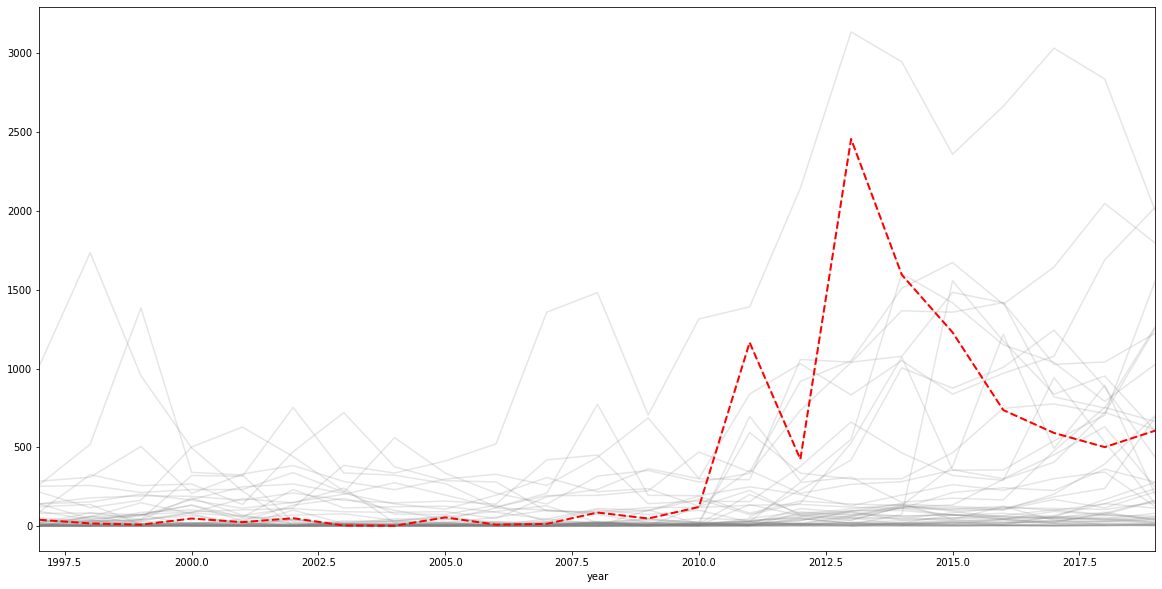

In [112]:
country_data(df, 'Egypt')

## ML models

In [ ]:
# Logistic Regression, K-Clustering
# https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

# Appendix: Data exploration

In [ ]:
# Plot variables sns
plt.rcParams['figure.figsize'] = (15, 8)

In [ ]:
print('Event types: {}\n'.format(df['event_type'].unique()))
print('Event subtypes: {}'.format(df['sub_event_type'].unique()))

In [ ]:
# Events
sns.countplot(x='event_type', color='lightcoral', data=df)

In [ ]:
# Plotting time series
# https://www.kaggle.com/lordkada/acled-simple-analysis

# All event 1997 - 2019
event_type = df.groupby(['date'])['event_type'].count()
event_type.plot(subplots=True, figsize=(20, 10), style='.', alpha=0.5)
print("1997-2019 - Number of events in {} countries: {}".
      format(df['country'].nunique(), df['event_type'].count()))

In [ ]:
# All subevents by date
sub_events = df.groupby(['date', 'sub_event_type'])['sub_event_type', ].count()
sub_events.reset_index(level=['date'], inplace= True)
sub_events.head()

In [ ]:
year = df.groupby(['year'])['event_type'].count()
year.plot(kind='bar', color = 'lightcoral')

In [ ]:
# Use rolling to deseasonalize data 
event_type['1999'].plot(figsize=(20,10), linewidth=5, fontsize=20, style='x', alpha = 0.5)
event_type['1999'].rolling(12).mean().plot(figsize=(20,10), linewidth=2, fontsize=20, alpha = 0.5)


In [ ]:
# Plot peaks/diff in data
event_type.plot(figsize=(20,10), linewidth=5, fontsize=20, style='.', alpha=0.2 )
event_type.diff().plot(figsize=(20,10), linewidth=1, fontsize=20, alpha=0.4 )